In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score

In [ ]:
### Data Loading and Exploration

# Paths (notebook is in `ml/`, dataset is in `ml/dataset/`)
ROOT = Path('.')
DATA_DIR = ROOT / 'dataset'
MODELS_DIR = ROOT / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_FILE = DATA_DIR / 'train.jsonl'
VAL_FILE = DATA_DIR / 'val.jsonl'
TEST_FILE = DATA_DIR / 'test.jsonl'

print("Checking data files:")
print(f"TRAIN_FILE exists: {TRAIN_FILE.exists()} - {TRAIN_FILE}")
print(f"VAL_FILE exists: {VAL_FILE.exists()} - {VAL_FILE}")
print(f"TEST_FILE exists: {TEST_FILE.exists()} - {TEST_FILE}")

# Load the datasets from jsonl files
def load_jsonl(path):
    if not path.exists():
        print(f"Warning: {path} does not exist")
        return pd.DataFrame()
    try:
        df = pd.read_json(path, lines=True)
        print(f"Loaded {path}: {len(df)} rows, columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return pd.DataFrame()

train_df = load_jsonl(TRAIN_FILE)
val_df = load_jsonl(VAL_FILE)
test_df = load_jsonl(TEST_FILE)

print("\nDataset sizes:")
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

if len(test_df) > 0:
    # Count the occurrences of labels in the testing set
    label_counts = test_df['label'].value_counts()
    print("\nLabel distribution in test set:")
    print(label_counts)

    # Display sample records
    print("\nSample training records:")
    display(train_df[['text', 'label']].head())
else:
    print("Warning: Test dataset is empty!")

Checking data files:
Resolved DATA_DIR: /content/dataset
TRAIN_FILE exists: False - dataset/train.jsonl
VAL_FILE exists: False - dataset/val.jsonl
TEST_FILE exists: False - dataset/test.jsonl

Dataset sizes:
Training set size: 0
Validation set size: 0
Testing set size: 0


In [19]:
# Inspect class distribution in each dataset
print("Class distribution analysis:")
print("\nTrain label distribution:")
if len(train_df) > 0 and 'label' in train_df.columns:
    print(train_df['label'].value_counts())
else:
    print("Train dataset is empty or missing 'label' column")

print("\nValidation label distribution:")
if len(val_df) > 0 and 'label' in val_df.columns:
    print(val_df['label'].value_counts())
else:
    print("Validation dataset is empty or missing 'label' column")

print("\nTest label distribution:")
if len(test_df) > 0 and 'label' in test_df.columns:
    print(test_df['label'].value_counts())
else:
    print("Test dataset is empty or missing 'label' column")

Class distribution analysis:

Train label distribution:
Train dataset is empty or missing 'label' column

Validation label distribution:
Validation dataset is empty or missing 'label' column

Test label distribution:
Test dataset is empty or missing 'label' column


In [20]:
### Data Preprocessing

# Clean text: remove URLs and extra whitespace
def clean_text(s):
    if not isinstance(s, str):
        return ''
    # Remove URLs
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    # Remove extra whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply cleaning to all datasets
train_df['text_clean'] = train_df['text'].astype(str).apply(clean_text)
val_df['text_clean'] = val_df['text'].astype(str).apply(clean_text)
test_df['text_clean'] = test_df['text'].astype(str).apply(clean_text)

# Display cleaned samples
print("Cleaned sample records:")
display(train_df[['text_clean', 'label']].head())

KeyError: 'text'

In [ ]:
### Feature Extraction with TF-IDF

# Define TF-IDF parameters
max_features = 30000
ngram_range = (1, 2)

# Initialize and fit TF-IDF vectorizer on training data
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features, analyzer='word')
X_train_tfidf = vectorizer.fit_transform(train_df['text_clean'])

# Transform validation and test data
X_val_tfidf = vectorizer.transform(val_df['text_clean'])
X_test_tfidf = vectorizer.transform(test_df['text_clean'])

print('Shape of training TF-IDF matrix:', X_train_tfidf.shape)
print('Shape of validation TF-IDF matrix:', X_val_tfidf.shape)
print('Shape of testing TF-IDF matrix:', X_test_tfidf.shape)

# Extract labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

Shape of training TF-IDF matrix: (11796, 30000)
Shape of validation TF-IDF matrix: (9045, 30000)
Shape of testing TF-IDF matrix: (9048, 30000)


In [ ]:
### Model Training

# Define model parameters
max_iter = 1000
solver = 'liblinear'
class_weight = 'balanced'

# Create and train Logistic Regression model
clf = LogisticRegression(max_iter=max_iter, solver=solver, class_weight=class_weight, random_state=42)
clf.fit(X_train_tfidf, train_labels)

print('Model training complete')
print(f'Model parameters: max_iter={max_iter}, solver={solver}, class_weight={class_weight}')

Model training complete
Model parameters: max_iter=1000, solver=liblinear, class_weight=balanced


In [ ]:
### Testing and Evaluation

# Evaluate on validation set
val_predictions = clf.predict(X_val_tfidf)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')

# Evaluate on test set
test_predictions = clf.predict(X_test_tfidf)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'\nTest Accuracy: {test_accuracy}')

# Detailed metrics (using average='weighted' for multi-class)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f'Precision (weighted): {precision}')
print(f'Recall (weighted): {recall}')
print(f'F1 Score (weighted): {f1}')

# Classification report
print('\n--- Classification Report ---')
print(classification_report(test_labels, test_predictions))

Validation Accuracy: 0.9893864013266999

Test Accuracy: 0.9880636604774535
Precision (weighted): 0.9881063159525512
Recall (weighted): 0.9880636604774535
F1 Score (weighted): 0.9880568364260581

--- Classification Report ---
              precision    recall  f1-score   support

          AI       0.99      0.98      0.99      4066
       HUMAN       0.98      0.99      0.99      4982

    accuracy                           0.99      9048
   macro avg       0.99      0.99      0.99      9048
weighted avg       0.99      0.99      0.99      9048

Precision (weighted): 0.9881063159525512
Recall (weighted): 0.9880636604774535
F1 Score (weighted): 0.9880568364260581

--- Classification Report ---
              precision    recall  f1-score   support

          AI       0.99      0.98      0.99      4066
       HUMAN       0.98      0.99      0.99      4982

    accuracy                           0.99      9048
   macro avg       0.99      0.99      0.99      9048
weighted avg       0.99   

In [ ]:
### Model Saving

# Save model and vectorizer as a bundle
artifact_path = MODELS_DIR / 'tfidf_logreg_sinhala.joblib'
joblib.dump({'vectorizer': vectorizer, 'model': clf}, artifact_path)
print(f'Saved model bundle to {artifact_path}')

# Also save separately for flexibility
joblib.dump(vectorizer, MODELS_DIR / 'tfidf_vectorizer.joblib')
joblib.dump(clf, MODELS_DIR / 'tfidf_logreg_model.joblib')
print(f'Saved separate artifacts to {MODELS_DIR}')

Saved model bundle to models\tfidf_logreg_sinhala.joblib
Saved separate artifacts to models
Saved separate artifacts to models


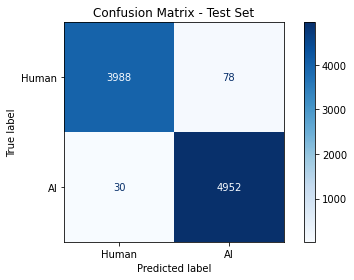

Confusion Matrix:
[[3988   78]
 [  30 4952]]


In [ ]:
### Visualization: Confusion Matrix

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'AI'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

print('Confusion Matrix:')
print(cm)

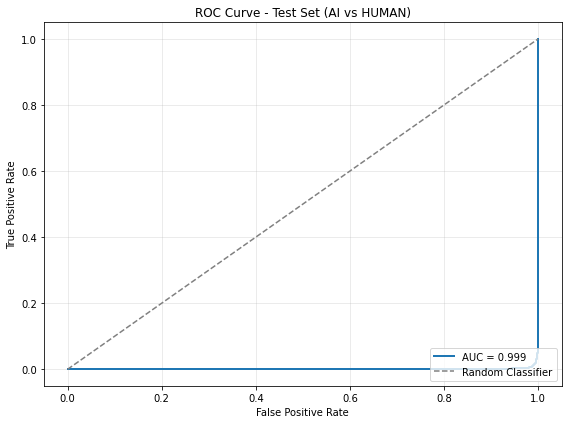

AUC Score: 0.999


In [ ]:
### Visualization: ROC Curve

# Get probabilities for ROC curve (for 'AI' class - the second column)
test_probabilities = clf.predict_proba(X_test_tfidf)[:, 1]
auc_score = roc_auc_score(test_labels, test_probabilities, multi_class='ovr')

# Calculate ROC curve (specify pos_label='AI' for binary classification against 'HUMAN')
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities, pos_label='AI')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (AI vs HUMAN)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'AUC Score: {auc_score:.3f}')

## Summary and Next Steps

### Model Performance
The TF-IDF + LogisticRegression model has been trained, evaluated, and saved. Review the metrics above to assess performance.

### Model Usage
Load and use the saved model:
```python
import joblib
bundle = joblib.load('models/tfidf_logreg_sinhala.joblib')
vectorizer = bundle['vectorizer']
model = bundle['model']

# Predict on new text
new_text = "Your Sinhala text here"
text_tfidf = vectorizer.transform([new_text])
prediction = model.predict(text_tfidf)
```

### Recommendations for Improvement
- Tune the TF-IDF parameters (ngram_range, max_features)
- Experiment with different LogisticRegression hyperparameters (C, penalty)
- Consider more advanced tokenization for Sinhala text
- Try other classifiers (SVM, Random Forest, Gradient Boosting)
- Use cross-validation and GridSearchCV for hyperparameter optimization
- Handle class imbalance if present using sampling techniques
- Add more training data if possible